<font color='green'>Дополнительные материалы по временным рядам:\
Б.Б. Демешев - временные ряды https://disk.yandex.ru/i/LiDHB-B3A6Lz5A \
Базовое применение ARIMA - https://colab.research.google.com/drive/17RnG91Eq8JBKyxToNzvCvjibfxum-oPj?usp=sharing \
Канторович - Анализ временных рядов https://yadi.sk/i/IOkUOS3hTXf3gg \
https://facebook.github.io/prophet/ \
https://facebook.github.io/prophet/docs/quick_start.html#python-api \
https://nbviewer.jupyter.org/github/miptgirl/habra_materials/blob/master/prophet/habra_data.ipynb 

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Подгружаем библиотеки

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import time 

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor 


state = 12345

Открываем файл, устанавливая индексом столбец с датой. Получаем информацию о датасете. Проверяем хронологичность расположения данных.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(data.head())
print(data.info())
print(data.describe())
data.index.is_monotonic

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


True

Данные расположены в хронологическом порядке. Сделаем ресемплирование количества заказов по одному часу.

In [3]:
data = data.resample('1H').sum()

Построим график количества заказов по времени.

<AxesSubplot:xlabel='datetime'>

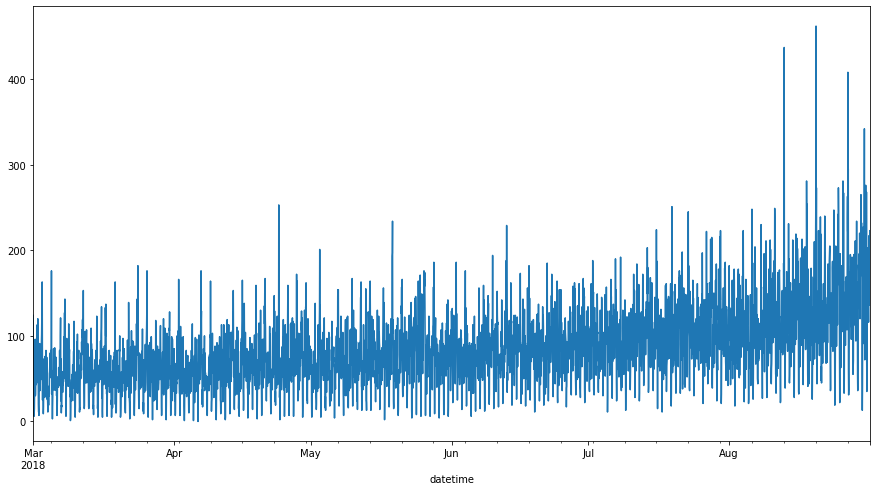

In [4]:
data['num_orders'].plot(figsize=(15,8))

График очень плотный и не очень информативный, далее проанализируем его.

## Анализ

Построим график по скользщему среднему со значением 50.

<AxesSubplot:xlabel='datetime'>

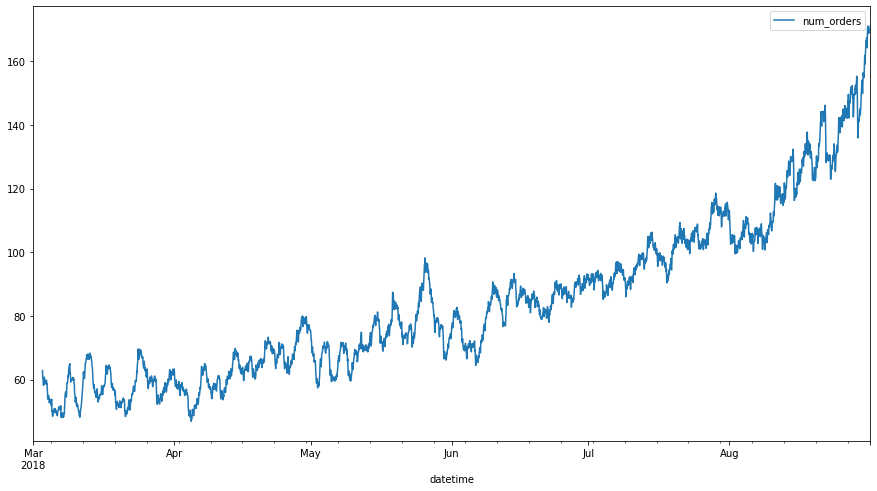

In [5]:
data.rolling(50).mean().plot(figsize=(15,8))

Видно, что намечается восходящий тренд. Далее рассмотрим период за один последний месяц. 

<AxesSubplot:xlabel='datetime'>

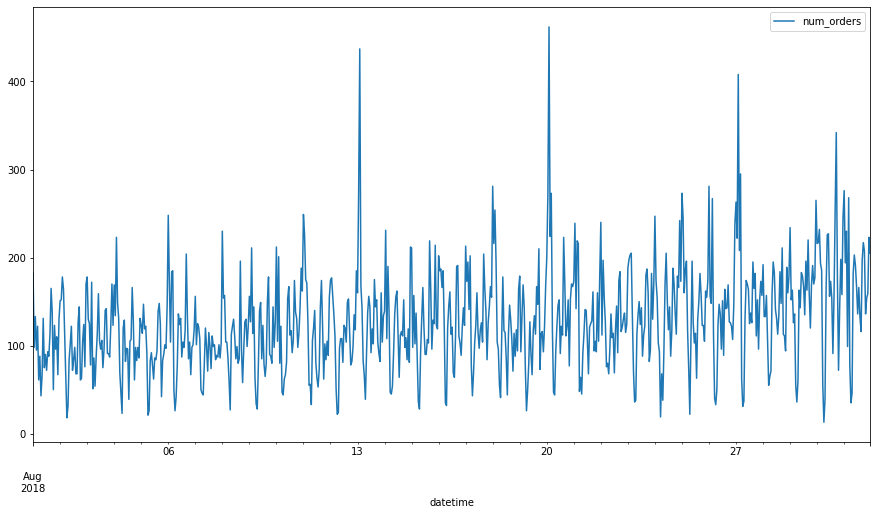

In [6]:
data['2018-08-01':'2018-08-31'].plot(figsize=(15,8))

График все еще плохо читается, но виден повышенный спрос 6, 13, 20, 27 августа 2018. Это понедельники. Далее Рассмотрим сезонность и тренд на графиках в разные пириоды с помощью метода декомпозиции. Сначала по целой таблице.

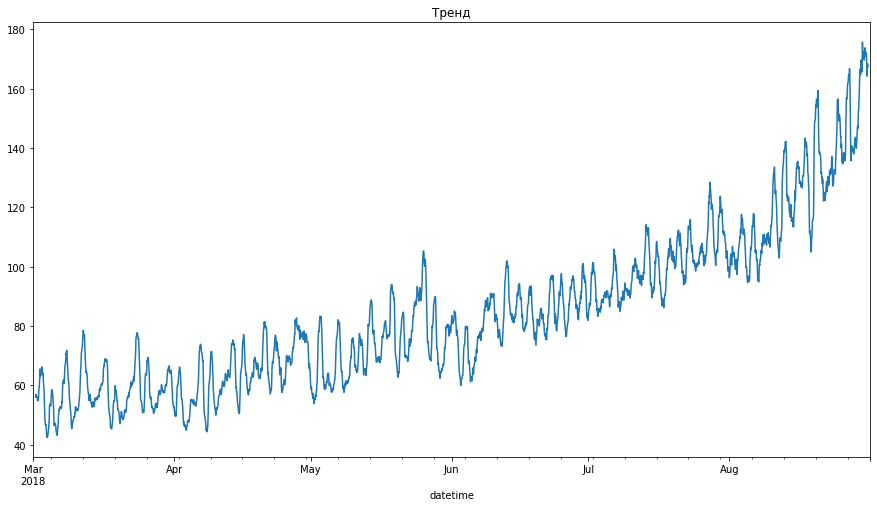

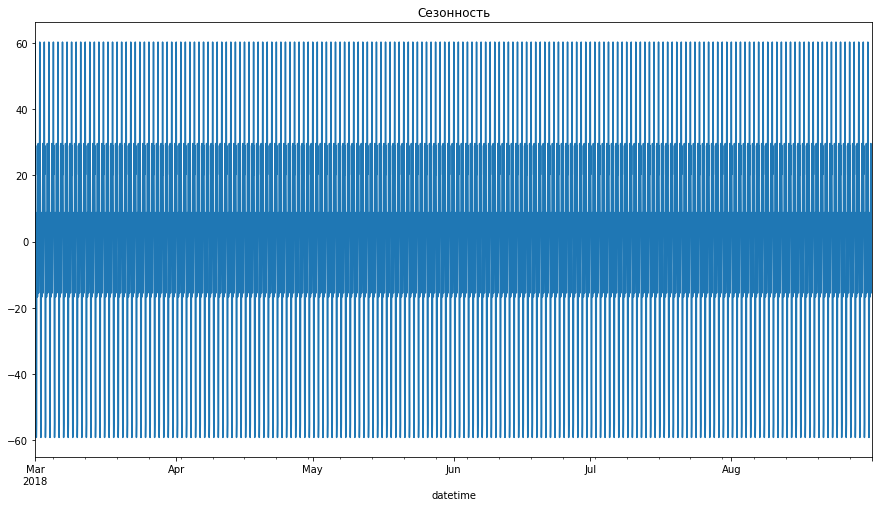

In [7]:
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(figsize=(15,8))
plt.title('Тренд')
plt.show()
decomposed_data.seasonal.plot(figsize=(15,8))
plt.title('Сезонность')
plt.show()

Тренд действительно восходящий. Сезонность определить сложно. Далее по данным за август.

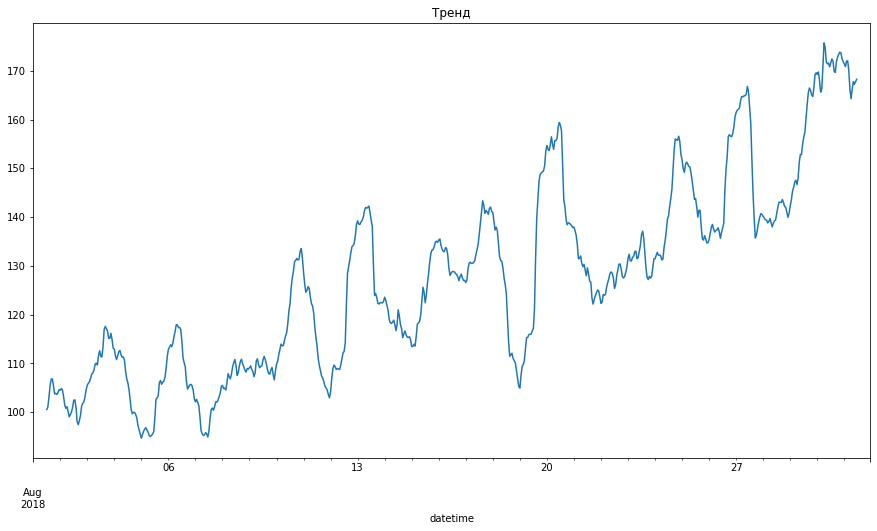

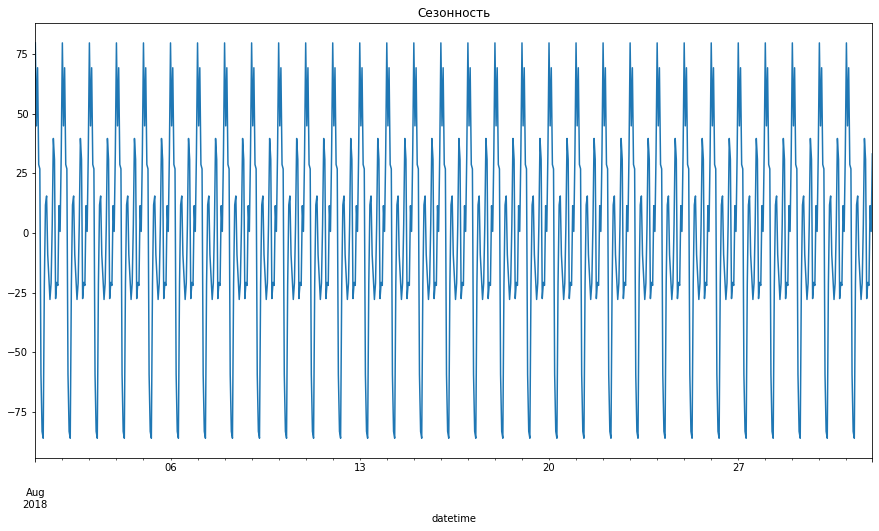

In [8]:
decomposed_data = seasonal_decompose(data['2018-08-01':'2018-08-31'])
decomposed_data.trend.plot(figsize=(15,8))
plt.title('Тренд')
plt.show()
decomposed_data.seasonal.plot(figsize=(15,8))
plt.title('Сезонность')
plt.show()

Тренд восходящий, сезонность ежедневная. Далее по данным за последнюю неделю.

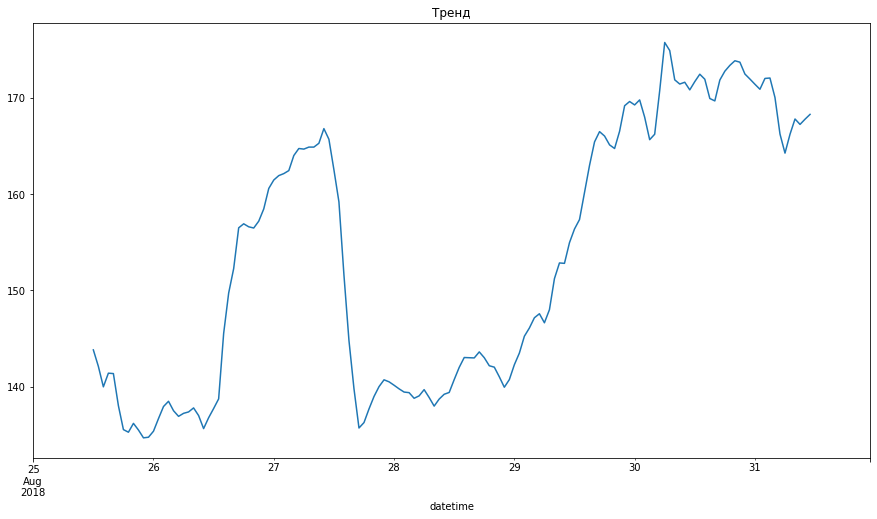

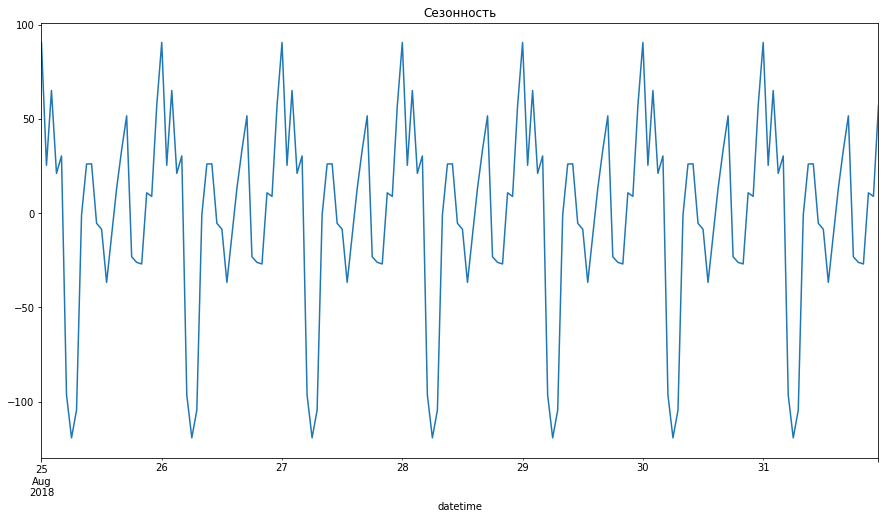

In [9]:
decomposed_data = seasonal_decompose(data['2018-08-25':'2018-08-31'])
decomposed_data.trend.plot(figsize=(15,8))
plt.title('Тренд')
plt.show()
decomposed_data.seasonal.plot(figsize=(15,8))
plt.title('Сезонность')
plt.show()

Видна ежедневная сезонность. Далее данные по 2 последним суткам.

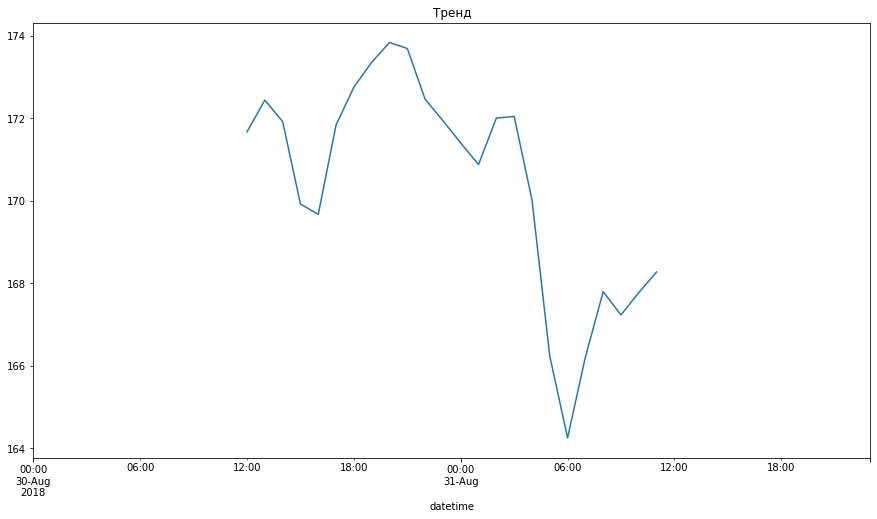

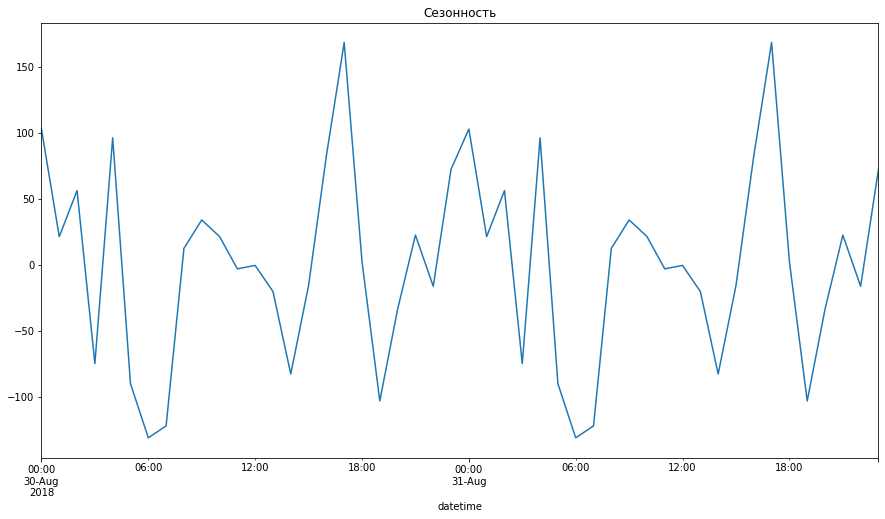

In [10]:
decomposed_data = seasonal_decompose(data['2018-08-30':'2018-08-31'])
decomposed_data.trend.plot(figsize=(15,8))
plt.title('Тренд')
plt.show()
decomposed_data.seasonal.plot(figsize=(15,8))
plt.title('Сезонность')
plt.show()

Далее проверим временной ряд н стационарность - ряд, у которого не меняются среднее и стандартное отклонения.

Видно, что в 6 утра спрос минимальный, а в вечерние часы спрос растет.

<AxesSubplot:xlabel='datetime'>

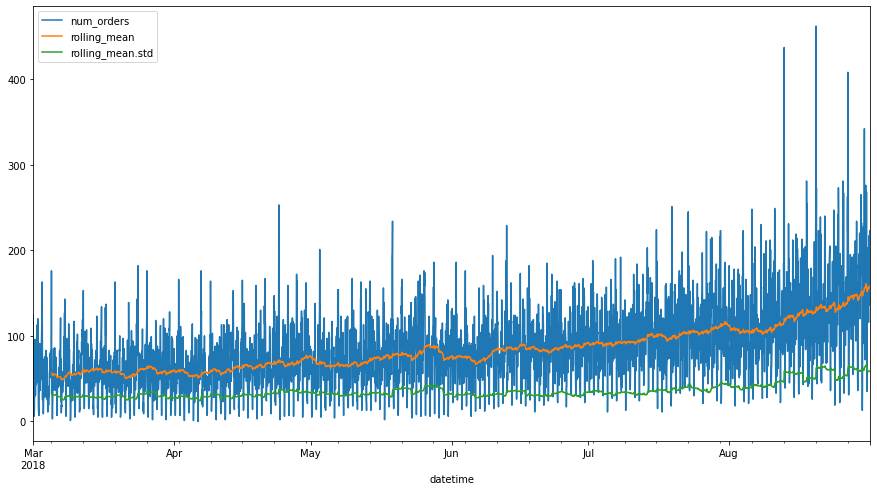

In [11]:
data_new = data.copy()
data_new['rolling_mean'] = data_new.rolling(100).mean()
data_new['rolling_mean.std'] = data_new['num_orders'].rolling(100).std()
data_new.plot(figsize=(15, 8))

Ряд не является стационарным, так как есть растущий тренд.

## Обучение

Создадим функцию для создания необходмых признаков для обучения моделей.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)


In [13]:
make_features(data, 10, 10)
data = data.dropna()

In [14]:
display(data.head())

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1


Разделим выборку на обучающую и тренировочную и разделим их на признаки и целевое значение.

In [15]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Проверим размеры получившихся выборок.

In [16]:
print(train.shape, train.index.min(), train.index.max())
print(test.shape, test.index.min(), test.index.max())

(3965, 15) 2018-03-01 10:00:00 2018-08-13 14:00:00
(441, 15) 2018-08-13 15:00:00 2018-08-31 23:00:00


Обучим модель линейной регрессии и расситаем rmse

In [17]:
%%time
ts_cv = TimeSeriesSplit(n_splits=10)
model_lr = LinearRegression()
rmse_lr = (cross_val_score(model_lr, features_train, target_train, cv=ts_cv, 
                             scoring='neg_root_mean_squared_error').mean() * -1) 
print('rmse_lr LR', rmse_lr)

rmse_lr LR 31.76143822017383
CPU times: user 119 ms, sys: 135 ms, total: 254 ms
Wall time: 203 ms


Значение метрики примерно 31,76. Время для обучения и рассчета - 203 мс. Далее обучим модель случайного леса с подбором гиперпараметров.

In [18]:
%%time
result_rf = 100
params_rf = []
for n in range(10, 31, 10):
    for i in range(1,11,2):
        model_rf = RandomForestRegressor(n_estimators=n, max_depth=i, random_state=state)
        rmse_rf = cross_val_score(model_rf, features_train, target_train, scoring='neg_root_mean_squared_error', cv=ts_cv, n_jobs=-1)
        final_rmse_rf = rmse_rf.mean()* (-1)
        if final_rmse_rf < result_rf:
            result_rf = final_rmse_rf
            params_rf = [n,i]
print(result_rf, params_rf)

25.182358416299344 [30, 9]
CPU times: user 15.9 s, sys: 138 ms, total: 16 s
Wall time: 16.1 s


Значение метрики примерно 25,18. Время для обучения и рассчета - 16,1 с. Далее обучим модель CatBoost

In [19]:
%%time
model_cb = CatBoostRegressor()
params = {
        'n_estimators' : [10, 50, 100],
        'random_state' : [state],
        'max_depth' : [3, 7, 10],
        'learning_rate' : [0.3, 0.7] 
    }
search = GridSearchCV(model_cb, params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=ts_cv)
search.fit(features_train, target_train)
rmse_cb = (search.best_score_) * (-1)
print('Best params for CatBoost: ', search.best_params_)
print('Best RMSE for CatBoost', rmse_cb)

0:	learn: 25.0610773	total: 46.6ms	remaining: 420ms
1:	learn: 23.6406640	total: 47.3ms	remaining: 189ms
2:	learn: 21.9716789	total: 47.8ms	remaining: 111ms
3:	learn: 21.0847852	total: 48.3ms	remaining: 72.4ms
4:	learn: 20.4135127	total: 48.7ms	remaining: 48.7ms
5:	learn: 19.7837849	total: 49.1ms	remaining: 32.7ms
6:	learn: 19.4562328	total: 49.5ms	remaining: 21.2ms
7:	learn: 19.1903240	total: 49.9ms	remaining: 12.5ms
8:	learn: 18.5233724	total: 50.3ms	remaining: 5.59ms
9:	learn: 18.0012574	total: 50.7ms	remaining: 0us
0:	learn: 25.7680197	total: 666us	remaining: 6ms
1:	learn: 24.3856019	total: 1.27ms	remaining: 5.08ms
2:	learn: 22.7914390	total: 1.89ms	remaining: 4.4ms
3:	learn: 21.7964262	total: 2.47ms	remaining: 3.7ms
4:	learn: 20.9248297	total: 2.96ms	remaining: 2.96ms
5:	learn: 20.4141760	total: 3.4ms	remaining: 2.27ms
6:	learn: 20.1229755	total: 3.98ms	remaining: 1.71ms
7:	learn: 19.6902089	total: 4.45ms	remaining: 1.11ms
8:	learn: 19.3399688	total: 4.92ms	remaining: 546us
9:	lear

Значение метрики примерно 24,48. Время для обучения и рассчета - 2м 42с. Далее обучим модель LGBM

In [20]:
%%time
model_LGBM = LGBMRegressor() 
params = {
        'num_leaves':[30, 100],
        'random_state' : [state],
        'learning_rate' :[0.1, 0.9] 
    }
search = GridSearchCV(model_LGBM, params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=ts_cv)
search.fit(features_train, target_train)
rmse_LGBM = (search.best_score_) * (-1)
print('Best params: ', search.best_params_)
print('Best RMSE', rmse_LGBM)

Best params:  {'learning_rate': 0.1, 'num_leaves': 30, 'random_state': 12345}
Best RMSE 24.933116614430517
CPU times: user 40.6 s, sys: 474 ms, total: 41 s
Wall time: 41.8 s


Значение метрики примерно 24,33. Время для обучения и рассчета - 43с. Это лучшее значение метрики из всех. С помощью этой модели и подобранных параметров посчитаем значение метрики на тестовой выборке.

## Тестирование

Обучаем модель с подобранными парамтрами и рассчитываем значение метрики.

In [21]:
model = LGBMRegressor(learning_rate=0.1, num_leaves=30, random_state=state) 
model.fit(features_train, target_train)
predict = model.predict(features_test)
print('Test RMSE', mean_squared_error(target_test, predict)**0.5)



Test RMSE 45.159493814030704


Сравним реальные данные и предсказания на графике.

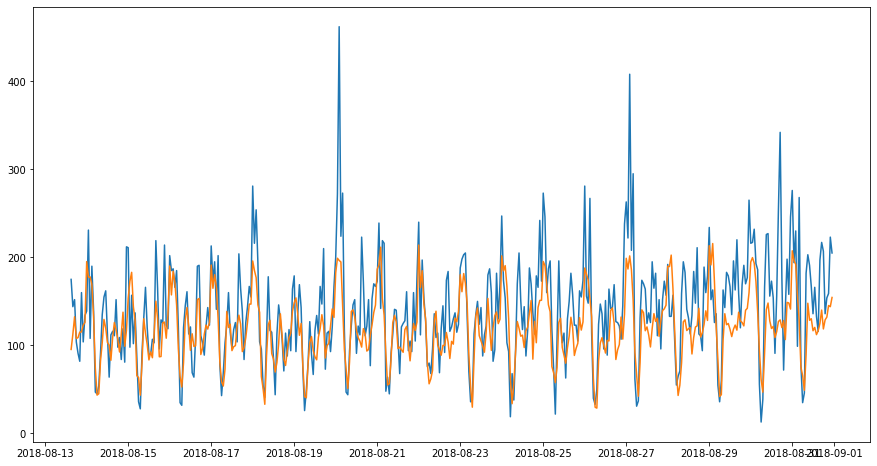

In [28]:
plt.figure(figsize=(15,8))
plt.plot(target_test.index, 
         target_test,  
         target_test.index, 
         predict)

Видно, что графики схожи.

Значение RMSE получилось примерно 42.86, что удовлетворяет поставленной задаче (<48 на тестовой выборке)

## Вывод

1. Нами были загружены и проанализированы данные.
2. Было обучено несколько моделей с подбором гиперпараметров.
3. Была рассчитана метрика RMSE для всех моделей и определена модель с лучшим показателем. Это оказалась модель LGBM.
4. Данная модель была обучена на тестовой выборке и для нее было рассчитано значение метрики. Оно удовлетворило условию задачи.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48